# "COVID-19 County Analysis"
> "Addressing some of the misconceptions surrounding the politicization of COVID-19."

- toc:true
- branch: master
- badges: true
- comments: true
- author: Jerry Lin
- categories: [covid-19, data-visualization]

The [most recent polling from Civiqs](https://civiqs.com/results/coronavirus_concern?annotations=true&uncertainty=true&zoomIn=true) shows a large discrepancy in COVID-19 sentiment, split along party lines:

|Party|Extremely<br>Concerned|Moderately<br>Concerned|A Little<br>Concerned|Not Concerned<br>At All|Unsure|
|---|---|---|---|---|---|
|Democrat|**63%**|27%|8%|2%|<1%|
|Republican|10%|22%|29%|**38%**|<1%|
|Independent|**34%**|26%|19%|20%|<1%|

Because of this, it can be easy for one's own party to blame the other, when the reality is probably more complex.

This post will focus on the following factors and how they relate to up-to-date COVID-19 data.

# About

## Data Sources
- The New York Times [COVID-19 repository](https://github.com/nytimes/covid-19-data)
- The [United States Census](https://www.census.gov/data.html)
- Plotly's [county-level GeoJSON](https://raw.githubusercontent.com/plotly/datasets/master/)
- [nomanatim](https://nominatim.openstreetmap.org/) and [polygons](http://polygons.openstreetmap.fr/)
- [github.com/tonmcg](https://github.com/tonmcg) and [RRH Elections](https://rrhelections.com/index.php/2018/02/02/alaska-results-by-county-equivalent-1960-2016/)

## How this data was merged
Refer to the following notebooks to follow along with this project:
- placeholder
- another placeholder

In [2]:
#hide
import json
from datetime import datetime, timedelta
from pytz import timezone
from time import time
from urllib.request import urlopen

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import altair as alt
from altair import datum
import matplotlib.pyplot as plt
import seaborn as sns

alt.data_transformers.enable('data_server');

In [3]:
#hide
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [22]:
#hide
df = optimize(pd.read_csv('data/df.csv'))
df['days'] = ((df['date'] - df['date'].min()) / np.timedelta64(1, 'D')).astype('int')
df['rate'] = df['deaths'] / df['cases']
la = timezone('US/Pacific')
last = df['date'].max()
df_slice = df[df['date'] == last]
df_slice.head()

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg,days,rate
78132,Alabama,8,2020-07-30,6235,94,Autauga-Chilton-Elmore-Shelby,399208.0,01001-01021-01051-01117,304138.0,61095.0,...,6.678571,0.107143,1.672955,0.026839,-10.950000,0.116667,-2.742931,0.029225,191,0.015076
78133,Alabama,5,2020-07-30,10943,207,Baldwin-Mobile,636444.0,01003-01097,419294.0,167703.0,...,115.500000,-0.392857,18.147709,-0.061727,10.416667,0.658333,1.636698,0.103439,191,0.018916
78134,Alabama,0,2020-07-30,15701,302,Barbour-Bullock-Chambers-Coffee-Dale-Geneva-He...,819084.0,01005-01011-01017-01031-01045-01061-01067-0106...,438765.0,309649.0,...,2.250000,0.035714,0.274697,0.004360,-16.466667,0.008333,-2.010376,0.001017,191,0.019234
78135,Alabama,1,2020-07-30,6580,153,Bibb-Butler-Conecuh-Covington-Crenshaw-Dallas-...,228314.0,01007-01013-01035-01039-01041-01047-01053-0108...,124301.0,92994.0,...,-1.178571,0.750000,-0.516206,0.328495,-7.941667,0.416667,-3.478397,0.182497,191,0.023252
78136,Alabama,7,2020-07-30,7932,70,Blount-Cullman-Limestone-Marshall-Morgan,456962.0,01009-01043-01083-01095-01103,369050.0,33012.0,...,66.857140,-1.785714,14.630788,-0.390780,24.258333,-0.466667,5.308610,-0.102124,191,0.008825


## Exploring the Correlations

The following are, upon shallow inspection, positively correlated with the total number of cases and deaths per county:
- population density (`pop_density`)
- percent black (`per_black`)
- percent hispanic (`per_hispanic`)
- percent of 25y+ without high school diploma or GED (`per_no_hs`)

The following are negatively correlated with the total number of cases and deaths per county:
- percent white (`per_white`)
- adjusted percent votes GOP in the 2016 general election (`per_gop`)
- educational coefficient (`edu`)
- mask discipline (`mask`)

In [7]:
#hide

def cov(x, y, w):
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(x, weights=w))) / np.sum(w)

def corr(x, y, w):
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

y_cols = ['pop_density', 
          'per_white', 'per_black', 'per_asian', 'per_hispanic', 
          'per_total_votes', 'per_gop', 
          'median_income', 
          'per_no_hs', 'per_some_hs', 'per_hs', 'per_some_college', 
          'per_associates', 'per_bachelors', 'per_graduate', 'edu', 'mask']
x_cols = y_cols + ['cases_per_100k', 'deaths_per_100k', 
                   'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg', 
                   'delta_new_cases_per_100k_15sg', 'delta_new_deaths_per_100k_15sg']
w_col = 'total_pop'

Text(0.5, 0.98, 'covid correlation heatmap')

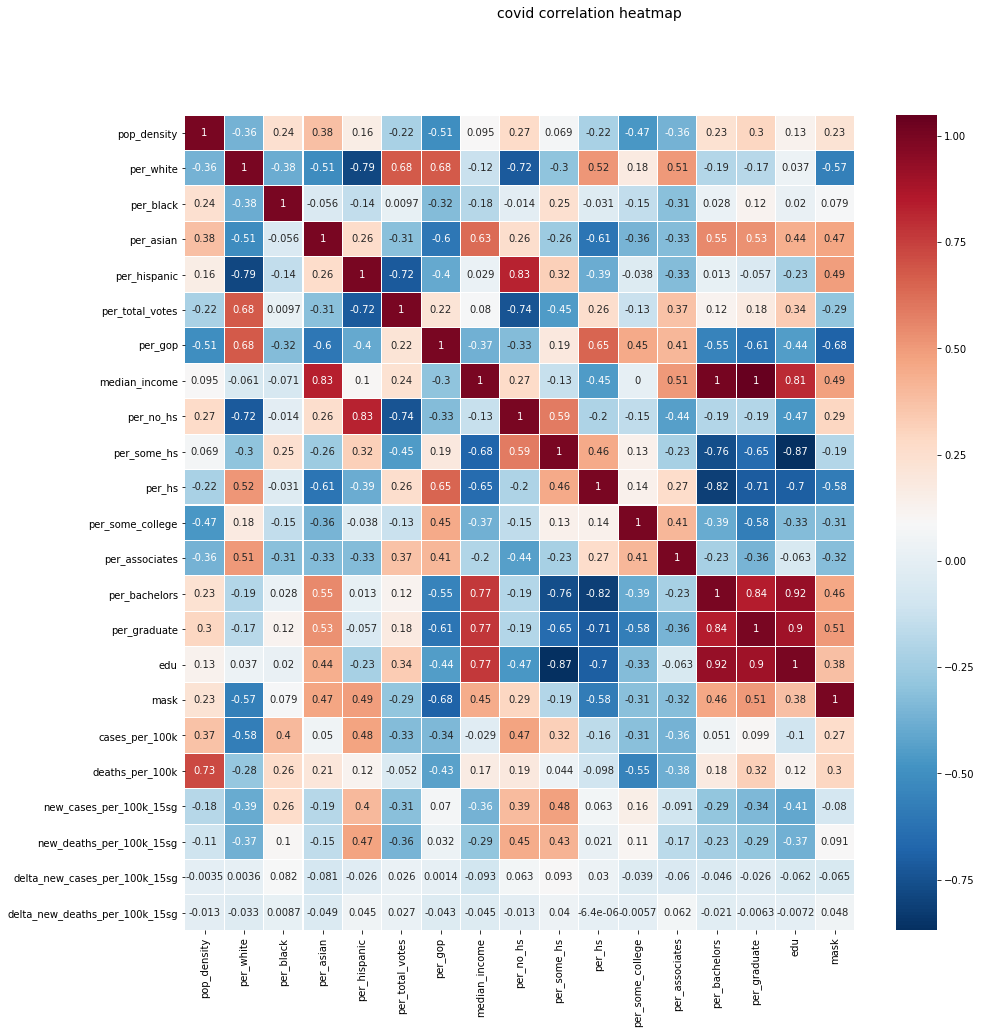

In [41]:
#hide_input
wcm = pd.DataFrame(index=x_cols, columns=y_cols)

for x in x_cols:
    for y in y_cols:
        wcm.loc[x, y] = corr(df_slice[x], df_slice[y], df_slice[w_col])
        
fig, (ax) = plt.subplots(1, 1, figsize=(15,15))

hm = sns.heatmap(np.array(wcm,dtype='float64'), 
                 ax=ax,
                 yticklabels=wcm.index,
                 xticklabels=wcm.columns,
                 cmap="RdBu_r",
                 annot=True, 
#                  fmt='.1f',
                 linewidths=.05)

# fig.subplots_adjust(top=0.93)
fig.suptitle('covid correlation heatmap', 
              fontsize=14)

# Scatter Plots (with color and size axes)

In each chart:

- color -- percent GOP (calculated as 2-party percentage) in the 2016 general election
- size -- total cases

In [167]:
#collapse-hide
def make_bubble_chart(df, params, line=True, split=False, clip=False):
    
    smax = np.max(df[params['s_col']])
    smax = smax + (-smax) % 10
    
    base = alt.Chart(df).properties(
        title=params['chart_title'],
        width=720,
        height=480
    )
    
    circles = base.mark_circle(stroke='black', strokeWidth=0.25, opacity=0.8).encode(
        x=alt.X(
            params['x_col'] + ':Q',
            scale=alt.Scale(type=params['x_scale'], zero=False)
        ),
        y=alt.Y(
            params['y_col'] + ':Q',
            scale=alt.Scale(type=params['y_scale'], zero=False)
        ),
        size=alt.Size(
            params['s_col'] + ':Q',
            scale=alt.Scale(
                domain=[1,smax],
                range=[10,2000]
            ),
        ),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=color_dict[params['c_col']]['scheme'],
                domain=[np.percentile(df[params['c_col']], 1), 
                        np.percentile(df[params['c_col']], 99)],
                domainMid=color_dict[params['c_col']]['mid'],
            ),
            sort=color_dict[params['c_col']]['sort'],
        ),
        tooltip=[
            'state:N', 'county:N', 'cases:Q', 'deaths:Q',
            alt.Tooltip(
                params['c_col'] + ':Q',
                format='.2f',
            ),
            alt.Tooltip(
                params['y_col'] + ':Q',
                format='.2f',
            ),
            alt.Tooltip(
                params['x_col'] + ':Q',
                format='.2f',
            )
        ]
    )
    
    def make_line(df, params, _split=None, _domain=None):
        colors = ['darkblue', 'firebrick']
        if _split in [0, 1]:
            df = df[df['gop']==_split]
            _color = colors[_split]
        else:
            _color = 'black'
        pfit = poly.polyfit(
            df[params['x_col']], 
            df[params['y_col']], 
            1, 
            w=df[params['w_col']]
        )
        fit = poly.polyval(np.unique(df[params['x_col']]), pfit)
        line_df = pd.DataFrame({
            'x': np.unique(df[params['x_col']]),
            'y': fit
        })
        _line = alt.Chart(line_df).mark_line(
            color=_color,
            strokeDash=[2,1],
            clip=True
        ).encode(
            x='x:Q',
            y=alt.Y(
                'y:Q', 
                scale=alt.Scale(domain=[
                    df[params['y_col']].min(),
                    df[params['y_col']].max()
                ])
            )
        )
        return _line
    
    if line:
        if split:
            _line0 = make_line(df, params, _split=0)
            _line1 = make_line(df, params, _split=1)
            return circles + _line0 + _line1
        else:
            _line = make_line(df, params)
            return circles + _line
        
    else:
        return circles

In [166]:
color_dict = dict(
    per_gop=dict(
        scheme='redblue',
        sort='descending',
        mid=0.5
    ),
    mask=dict(
        scheme='brownbluegreen',
        sort='ascending',
        mid=pop_df_ac['mask'].median()
    ),
    median_income=dict(
        scheme='purplegreen',
        sort='ascending',
        mid=61937
    ),
    edu=dict(
        scheme='blueorange',
        sort='ascending',
        mid=pop_df_ac['edu'].median()
    )
)

## COVID-19 Density and Mortality Rate vs. Population Density

In [168]:
#hide_input
params = dict(
    chart_title='Case Density vs. Population Density',
    x_col='pop_density',
    x_scale='sqrt',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

case_pop = make_bubble_chart(df_slice, params)
case_pop

alt.LayerChart(...)

By far the largest predictor of total cases/deaths is population density. This does not appear to be an unfair characterization, given the fact that the disease spreads from person-to-person. Dense urban centers tend to lean Democratic, whereas sparse rural counties tend to lean Republican. Therefore, it makes sense that urban Democratic centers are being hit harder than their rural Republican counterparts.

The effects of urban density are further illustrated when discussing the mortality rate. In New York City, over 10% of those diagnosed have passed due to complications from the virus.

In [169]:
#hide_input
params = dict(
    chart_title='Mortality Rate vs. Population Density',
    x_col='pop_density',
    x_scale='sqrt',
    y_col='rate',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

death_pop = make_bubble_chart(df_slice, params)
death_pop

alt.LayerChart(...)

## COVID-19 Density vs. Median Income

In [170]:
#hide_input
params = dict(
    chart_title='Case Density vs. Median Income',
    x_col='median_income',
    x_scale='linear',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

case_inc = make_bubble_chart(df_slice, params)
case_inc

alt.LayerChart(...)

In [171]:
#hide_input
params = dict(
    chart_title='Mortality Rate vs. Median Income',
    x_col='median_income',
    x_scale='linear',
    y_col='rate',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

case_edu = make_bubble_chart(df_slice, params)
case_edu

alt.LayerChart(...)

## COVID-19 Density vs. Educational Attainment

Educational attainment (`edu`) is defined as the weighted average of the highest degree of education for persons 25 and older within a given county:

- no HS -- 0
- some HS -- 1
- HS diploma or GED -- 2
- some college -- 3
- associate's degree -- 4
- bachelor's degree -- 5
- graduate or professional degree - 6

In [172]:
#hide_input
params = dict(
    chart_title='Cases per 100k vs. Educational Attainment (% GOP)',
    x_col='edu',
    x_scale='linear',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

case_edu = make_bubble_chart(df_slice, params)
case_edu

alt.LayerChart(...)

In [173]:
#hide_input
params = dict(
    chart_title='Mortality Rate vs. Educational Attainment (% GOP)',
    x_col='edu',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

new_case_edu = make_bubble_chart(df_slice, params)
new_case_edu

alt.LayerChart(...)

## COVID-19 Density vs. Mask Discipline

Mask discipline (`edu`) is defined as the weighted average of the answer to the following question: "How often do you wear a mask in public when you expect to be within six feet of another person?"

- never -- 0
- rarely -- 1
- sometimes -- 2
- frequently -- 3
- always -- 4

In [181]:
#hide_input
params = dict(
    chart_title='Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='cases_per_100k',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [182]:
#hide_input
params = dict(
    chart_title='New Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [183]:
#hide_input
params = dict(
    chart_title='Change in New Cases per 100k vs. Mask Discipline (% GOP)',
    x_col='mask',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

In [184]:
#hide_input
params = dict(
    chart_title='Case Density vs. Population Density (Mask Discipline)',
    x_col='pop_density',
    x_scale='sqrt',
    y_col='new_cases_per_100k_15sg',
    y_scale='sqrt',
    s_col='cases',
    c_col='mask',
    w_col='total_pop'
)

mask_edu = make_bubble_chart(df_slice, params)
mask_edu

alt.LayerChart(...)

# New Cases per 100k vs. Population Density, Education, and Mask Discipline

Mask use seems to increase with educational attainment and is somehow a partisan issue, with Republican counties having worse mask discipline. With the size of the circles representing new cases, we see that counties with a high education attainment and mask discipline ratines (top-right quadrant) seem to have a lower number of new cases than those with low education and mask discipline (bottom-left quadrant).

In [205]:
#hide_input
params = dict(
    chart_title='Case Density vs. Population Density, Education, and Mask Discipline',
    x_col='edu',
    x_scale='linear',
    y_col='mask',
    y_scale='linear',
    s_col='new_cases_per_100k_15sg',
    c_col='per_gop',
    w_col='total_pop'
)

medley = make_bubble_chart(df_slice, params)
medley

alt.LayerChart(...)

## New Cases per 100k vs. Percent GOP

Recent COVID-19 cases, however, seem to be more prevalent in more GOP-weighted counties.

In [185]:
#hide_input
params = dict(
    chart_title='New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

new_case_gop = make_bubble_chart(df_slice, params)
new_case_gop

alt.LayerChart(...)

This is most likely skewed by the fact that New York City -- a prior epicenter of COVID-19 cases and the largest group in this dataset -- has relatively few cases now.

In [186]:
#hide_input
params = dict(
    chart_title='New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

new_case_gop_split = make_bubble_chart(df_slice, params, split=True)
new_case_gop_split

alt.LayerChart(...)

## Change in New Cases per 100k vs. Percent GOP

Changes in cases do not seem to be predicted by political affiliation.

In [187]:
#hide_input
params = dict(
    chart_title='Change in New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

del_case_gop = make_bubble_chart(df_slice, params)
del_case_gop

alt.LayerChart(...)

In [188]:
#hide_input
params = dict(
    chart_title='Change in New Cases vs. Percent GOP',
    x_col='per_gop',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

del_case_gop_split = make_bubble_chart(df_slice, params, split=True)
del_case_gop_split

alt.LayerChart(...)

## Case Rate Charts

Counties in the upper right portion of this chart face the highest risk of a worsening pandemic.

In [190]:
#hide_input
params = dict(
    chart_title='Change in New Cases vs. New Cases, per 100k',
    x_col='new_cases_per_100k',
    x_scale='linear',
    y_col='delta_new_cases_per_100k_15sg',
    y_scale='linear',
    s_col='cases',
    c_col='per_gop',
    w_col='total_pop'
)

delta_new_case_gop_split = make_bubble_chart(df_slice, params, split=True)
delta_new_case_gop_split

alt.LayerChart(...)

# "Iceberg" Plots

I've coined the term "iceberg" to refer to a stacked area chart where the two halves are split along the color axis. The two halves are engineered in a way that their cumulative sum populations are approximately equal to each other.

In [77]:
pop_df_ac = optimize(pd.read_csv('data/pop_df_ac.csv'))

In [191]:
#collapse-hide
def make_iceberg_chart(df, pop_df_ac, params):
    
    # https://stackoverflow.com/a/41489086
    # find cutoff to split dataframe into equal-population halves
    total = pop_df_ac['total_pop'].sum()
    half = total / 2
    sorted_pop_df_ac = pop_df_ac.sort_values(by=params['c_col'])
    # returns last index where cumsum < half
    cutoff_idx = np.flatnonzero(sorted_pop_df_ac['total_pop'].cumsum() < half)[-1]
    cutoff_val = sorted_pop_df_ac[params['c_col']].iloc[cutoff_idx]
    
    # checks the half
    h0 = sorted_pop_df_ac['total_pop'][:cutoff_idx + 1].sum() / total
    print(f'{h0*100:.1f}')
    
    base = alt.Chart(df).properties(
        title=params['chart_title'],
        width=720,
        height=480
    )
    
    c_datum = 'datum.' + params['c_col']
    
    # top of iceberg: c_col > cutoff_val
    top = base.mark_area(opacity=0.8).transform_filter(
        (eval(c_datum) > cutoff_val)
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y(params['y_col'] + ':Q'),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=color_dict[params['c_col']]['scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 1), 
                        np.percentile(df[params['c_col']].unique(), 99)],
                domainMid=color_dict[params['c_col']]['mid'],
            ),
            sort=color_dict[params['c_col']]['sort'],
        ),
        order=alt.Order(params['c_col'], sort='ascending')
    )
    
    # bottom of iceberg: c_col <= cutoff_val
    bottom = base.mark_area(opacity=0.8).transform_filter(
        (eval(c_datum) <= cutoff_val)
    ).transform_calculate(
        y_alt='datum.' + params['y_col'] + '* -1'
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y('y_alt:Q', axis=alt.Axis(format='(.2s')),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=color_dict[params['c_col']]['scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 1), 
                        np.percentile(df[params['c_col']].unique(), 99)],
                domainMid=color_dict[params['c_col']]['mid'],
            ),
            sort=color_dict[params['c_col']]['sort'],
        ),
        order=alt.Order(params['c_col'], sort='descending')
    )
    
    df['zero'] = 0
    zero = base.mark_line(color='black').encode(
        x='date',
        y='zero',
        size=alt.value(0.5)
    )
    
    layer = alt.layer(top, bottom, zero).encode(
        tooltip=[
            'state:N', 'county:N', 'date:T',
            alt.Tooltip(
                params['y_col'] + ':Q',
                format='.2f',
            )
        ]
    )
    
    return layer

In [192]:
#hide
def make_iceberg_chart_2(df, pop_df_ac, params):
    
    # https://stackoverflow.com/a/41489086
    # find cutoff to split dataframe into equal-population halves
    total = pop_df_ac['total_pop'].sum()
    half = total / 2
    sorted_pop_df_ac = pop_df_ac.sort_values(by=params['c_col'])
    # returns last index where cumsum < half
    cutoff_idx = np.flatnonzero(sorted_pop_df_ac['total_pop'].cumsum() < half)[-1]
    cutoff_val = sorted_pop_df_ac[params['c_col']].iloc[cutoff_idx]
    
    # checks the half
    h0 = sorted_pop_df_ac['total_pop'][:cutoff_idx + 1].sum() / total
    print(f'{h0*100:.1f}')
    
    base = alt.Chart(df).properties(
        title=params['chart_title'],
        width=720,
        height=480
    )
    
    c_datum = 'datum.' + params['c_col']
    
    # top of iceberg: c_col > cutoff_val
    points0 = base.mark_area().transform_filter(
        (eval(c_datum) > cutoff_val)
    ).transform_joinaggregate(
        cases0='sum(cases)'
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y(params['y_col'] + ':Q'),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=params['c_scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 0.5), 
                        np.percentile(df[params['c_col']].unique(), 99.5)],
                domainMid=params['c_mid'],
            ),
            sort=params['c_sort'],
        ),
        order=alt.Order(params['c_col'], sort='ascending')
    )
    
    # bottom of iceberg: c_col <= cutoff_val
    points1 = base.mark_area().transform_filter(
        (eval(c_datum) <= cutoff_val)
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y('y_alt:Q', axis=alt.Axis(format='(.2s')),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=params['c_scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 1), 
                        np.percentile(df[params['c_col']].unique(), 99)],
                domainMid=params['c_mid'],
            ),
            sort=params['c_sort'],
        ),
        order=alt.Order(params['c_col'], sort='descending'),
    )
    
    line = base.mark_line(
        color='red'
    ).transform.calculate(
        is_top = c_datum + '> cu'
    ).encode(
        x='date',
        y='ratio'
    )
    
    df['zero'] = 0
    zero = base.mark_line(color='black').encode(
        x='date',
        y='zero',
        size=alt.value(0.5)
    )
    
    layer = alt.layer(points0, points1, line, zero).encode(
        tooltip=[
            'state:N', 'county:N', 'date:T',
            alt.Tooltip(
                params['y_col'] + ':Q',
                format='.2f',
            )
        ]
    )
    
    return layer

## Comparing New Cases vs. Percent GOP

In [193]:
#hide_input
params = dict(
    chart_title='Cases per Day vs. Percent GOP',
    y_col='new_cases',
    c_col='per_gop'
)

ice_gop = make_iceberg_chart(df, pop_df_ac, params)
# ice_gop.save('docs/ice_gop.html')
ice_gop

49.9


alt.LayerChart(...)

Democratic counties still comprise most daily cases compared to their Republican counterparts. However, when splitting the country into "Democratic" and "Republican" halves, we see that Republican-leaning counties currently account for more than half of the new daily cases.

In [129]:
#hide_input
norm_cases = alt.Chart(df).mark_area().encode(
    alt.X('date:T', title='Date'),
    alt.Y('cases:Q', stack='normalize'),
    color=alt.Color(
        'per_gop' + ':Q',
        scale=alt.Scale(
            scheme='redblue',
            domain=[np.percentile(df['per_gop'].unique(), 1), 
                    np.percentile(df['per_gop'].unique(), 99)],
            domainMid=0.5,
        ),
        sort='descending',
    ),
)

# norm_cases.save('docs/norm_cases.html')
norm_cases

alt.Chart(...)

When looking at the share of total cases, Republican counties are catching up due to the virus hitting the Southern states.

In [130]:
#hide_input
norm_new_cases = alt.Chart(df).mark_area().encode(
    alt.X('date:T', title='Date'),
    alt.Y('new_cases:Q', stack='normalize'),
    color=alt.Color(
        'per_gop' + ':Q',
        scale=alt.Scale(
            scheme='redblue',
            domain=[np.percentile(df['per_gop'].unique(), 1), 
                    np.percentile(df['per_gop'].unique(), 99)],
            domainMid=0.5,
        ),
        sort='descending',
    ),
)

# norm_new_cases.save('docs/norm_new_cases.html')
norm_new_cases

alt.Chart(...)

## Comparing New Cases vs. Educational Attainment

Counties with lower educational attainment coefficient have a disproportionate share of new cases:

In [194]:
#hide_input
params = dict(
    chart_title='Cases per Day vs. Educational Attainment',
    y_col='new_cases',
    c_col='edu',
)

ice_edu = make_iceberg_chart(df, pop_df_ac, params)
# ice_edu.save('docs/ice_edu.html')
ice_edu

48.4


alt.LayerChart(...)

## Comparing New Cases vs. Median Income

Strangely enough, while there didn't seem to be a large correlation between new cases and median income (for the most recent 15-day window), we can see from this iceberg plot that low-income counties are currently disproportionately affected by COVID-19.

In [195]:
#hide_input
params = dict(
    chart_title='Cases per Day vs. Median Income',
    y_col='new_cases',
    c_col='median_income'
)

ice_inc = make_iceberg_chart(df, pop_df_ac, params)
# ice_inc_normed.save('docs/ice_inc_normed.html')
ice_inc

48.9


alt.LayerChart(...)

## Comparing New Cases vs. Mask Discipline

While dense counties were hit the hardest in the beginning, they seem to be doing slightly better

In [197]:
#hide_input
params = dict(
    chart_title='Cases per Day vs. Median Income',
    y_col='new_cases',
    c_col='mask'
)

ice_mask = make_iceberg_chart(df, pop_df_ac, params)
# ice_inc_normed.save('docs/ice_inc_normed.html')
ice_mask

50.0


alt.LayerChart(...)

In [ ]:
#hide
def make_normed_iceberg_chart(df, params):
    
    base = alt.Chart(df).properties(
        title=params['chart_title'],
        width=720,
        height=480
    )
    
    c_datum = 'datum.' + params['c_col']
    y_datum = 'datum.' + params['y_col']
    
    # top of iceberg
    points0 = base.mark_area().transform_filter(
        (eval(c_datum) >= params['c_mid'])
    ).transform_joinaggregate(
        pop_0='sum(total_pop)',
    ).transform_calculate(
        per_y=y_datum + ' / datum.pop_0'
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y('per_y:Q'),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=params['c_scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 0.5), 
                        np.percentile(df[params['c_col']].unique(), 99.5)],
                domainMid=params['c_mid'],
            ),
            sort=params['c_sort'],
        ),
        order=alt.Order(params['c_col'], sort='ascending')
    )
    
    # bottom of iceberg
    points1 = base.mark_area().transform_filter(
        (eval(c_datum) < params['c_mid'])
    ).transform_joinaggregate(
        pop_1='sum(total_pop)',
    ).transform_calculate(
        per_y=y_datum + ' / datum.pop_1 * -1'
    ).encode(
        alt.X('date:T', title='Date'),
        alt.Y('per_y:Q', axis=alt.Axis(format='(.2s')),
        color=alt.Color(
            params['c_col'] + ':Q',
            scale=alt.Scale(
                scheme=params['c_scheme'],
                domain=[np.percentile(df[params['c_col']].unique(), 1), 
                        np.percentile(df[params['c_col']].unique(), 99)],
                domainMid=params['c_mid'],
            ),
            sort=params['c_sort'],
        ),
        order=alt.Order(params['c_col'], sort='descending'),
    )
    
    df['zero'] = 0
    zero = base.mark_line(color='black').encode(
        x='date',
        y='zero',
        size=alt.value(0.5)
    )
    
    layer = alt.layer(points0, points1, zero).encode(
        tooltip=[
            'state:N', 'county:N',
            alt.Tooltip(
                params['y_col'] + ':Q',
                format='.0f',
            )
        ]
    )
    
    return layer